<div>
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Smart Supply Chain </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[Emlyon]</a> MSc in Data Science & Artificial Intelligence Strategy (DSAIS) <br/>
         January 2024, Paris | © Saeed VARASTEH
    </span>
</div>

### Part 04 : Time Series Forecasting | Machine Learning Models

This lecture content will be on machine learning models in time series forecasting.

---

__Can you estimate, as precisely as possible, the point forecasts of the unit sales of various products sold in the USA by Walmart?__

You will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

The sales information reaches back from Jan 2011 to June 2016.

The data comprises 3049 individual products from 3 categories and 7 departments (sub-category), sold in 10 stores in 3 states. 

The objective is to predict sales for all products in each store for the next 28 days.

<img align="right" src="images/walmart.jpeg" style="width:100px; paddgin:5px"/>


__Dataset description__

You are given these files:

<ul>
<li>
<b>sales.csv</b>: Contains the historical daily unit sales data.
<ul>
<li>This is our main training data. It has 1 column for each of the 1,941 days from 2011-01-29 and 2016-05-22.</li>
<li>We use 1,913 days for the training and 28 days for the evaluation.</li>
<li>It also includes the IDs for item, department, category, store, and state.</li> 
<li>The number of rows is 30490 for all combinations of 3049 items and 10 stores.</li>
</ul>
</li>
<li>
<b>calendar.csv</b>: Contains information about the dates on which the products are sold.
<ul>
<li>Dates are together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).
</li>
</ul>
</li>
<li>
<b>prices.csv</b>: Contains information about the price of the products sold per store and date.
</li>
</ul>

---

### Import data and modules

#### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

C:\Users\romai\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Import data

In [2]:
sales = pd.read_csv('./data/walmart/sales.csv')
print(sales.shape)
sales.head(5)

(30490, 1947)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [3]:
cal = pd.read_csv('./data/walmart/calendar.csv')
print(cal.shape)
cal.head(5)

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
price = pd.read_csv('./data/walmart/prices.csv')
print(price.shape)
price.head(5)

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


---

## <span style="color:steelblue;">  Data Exploration  </span>


### Visualize the sales data for one unique product

#### Extract product data

In [5]:
d_cols = [col for col in sales.columns if 'd_' in col] 
df_product = sales.loc[sales['id'] == 'FOODS_3_090_CA_3_evaluation'][d_cols].T
print(df_product.shape)
df_product.head(10)

(1941, 1)


,8412
d_1,108
d_2,132
d_3,102
d_4,120
d_5,106
d_6,123
d_7,279
d_8,175
d_9,186
d_10,120


#### Rename sales column and extract index

In [6]:
df_product = df_product.rename(columns={8412:'sales'})
df_product = df_product.reset_index().rename(columns={'index': 'd'})
df_product.head(10)

,d,sales
0,d_1,108
1,d_2,132
2,d_3,102
3,d_4,120
4,d_5,106
5,d_6,123
6,d_7,279
7,d_8,175
8,d_9,186
9,d_10,120


#### Merge with the calendar data

In [7]:
df_product = df_product.merge(cal, on="d", how='left', validate='1:1')
df_product.head(10)

,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,108,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,132,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,102,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,120,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,106,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
5,d_6,123,2011-02-03,11101,Thursday,6,2,2011,NaN,NaN,NaN,NaN,1,1,1
6,d_7,279,2011-02-04,11101,Friday,7,2,2011,NaN,NaN,NaN,NaN,1,0,0
7,d_8,175,2011-02-05,11102,Saturday,1,2,2011,NaN,NaN,NaN,NaN,1,1,1
8,d_9,186,2011-02-06,11102,Sunday,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
9,d_10,120,2011-02-07,11102,Monday,3,2,2011,NaN,NaN,NaN,NaN,1,1,0


#### Remove al columns except `date` and `sales` from `df_product`

In [8]:
df_product = df_product[["date","sales"]]
df_product.head()

,date,sales
0,2011-01-29,108
1,2011-01-30,132
2,2011-01-31,102
3,2011-02-01,120
4,2011-02-02,106


#### Check for `null` values

In [9]:
df_product.isnull().sum()

date     0
sales    0
dtype: int64

#### Convert  `date`  column to datetime

In [10]:
df_product['date'] = pd.to_datetime(df_product['date'])
df_product.head()

,date,sales
0,2011-01-29,108
1,2011-01-30,132
2,2011-01-31,102
3,2011-02-01,120
4,2011-02-02,106


#### Set  `date`  as index

In [11]:
df_product.set_index('date', inplace=True, drop=True)
df_product.head(5)

,sales
date,
2011-01-29,108
2011-01-30,132
2011-01-31,102
2011-02-01,120
2011-02-02,106


#### Plot daily sales data

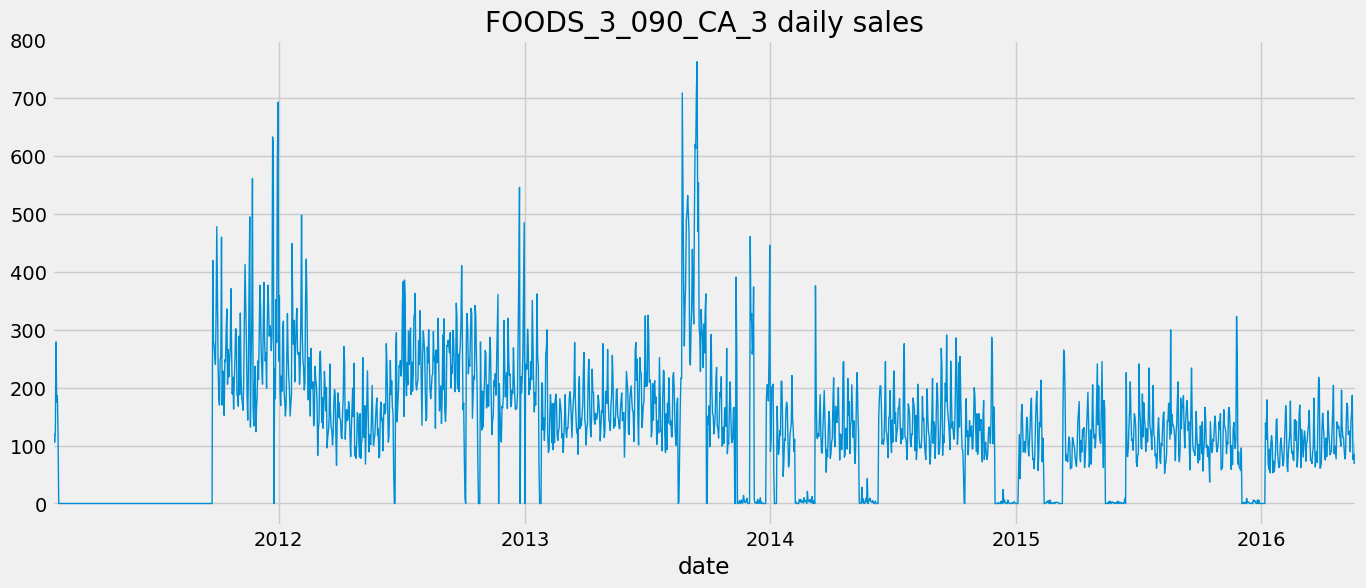

In [12]:
fig = plt.figure(figsize=(15, 6))
df_product["sales"].plot(kind="line", title="FOODS_3_090_CA_3 daily sales", lw=1);

#### Grouping `sales` according to `month` and plot the average monthly data

##### <span style="color:gray">Option 1</span>

In [13]:
df_product_month_1 = df_product.groupby(pd.PeriodIndex(df_product.index, freq="M"))['sales'].mean()

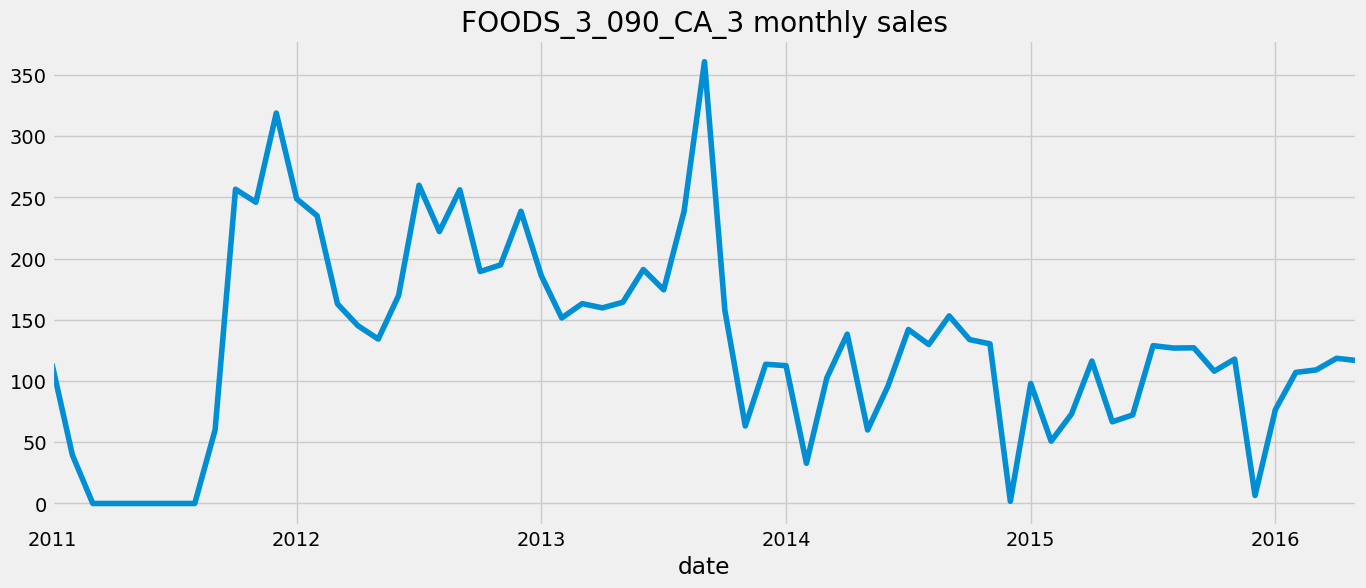

In [14]:
fig = plt.figure(figsize=(15, 6))
df_product_month_1.plot(kind="line", title="FOODS_3_090_CA_3 monthly sales");

##### <span style="color:gray">Option 2</span>

In [15]:
df_product_month_2 = df_product.groupby([df_product.index.year,df_product.index.month])['sales'].mean()

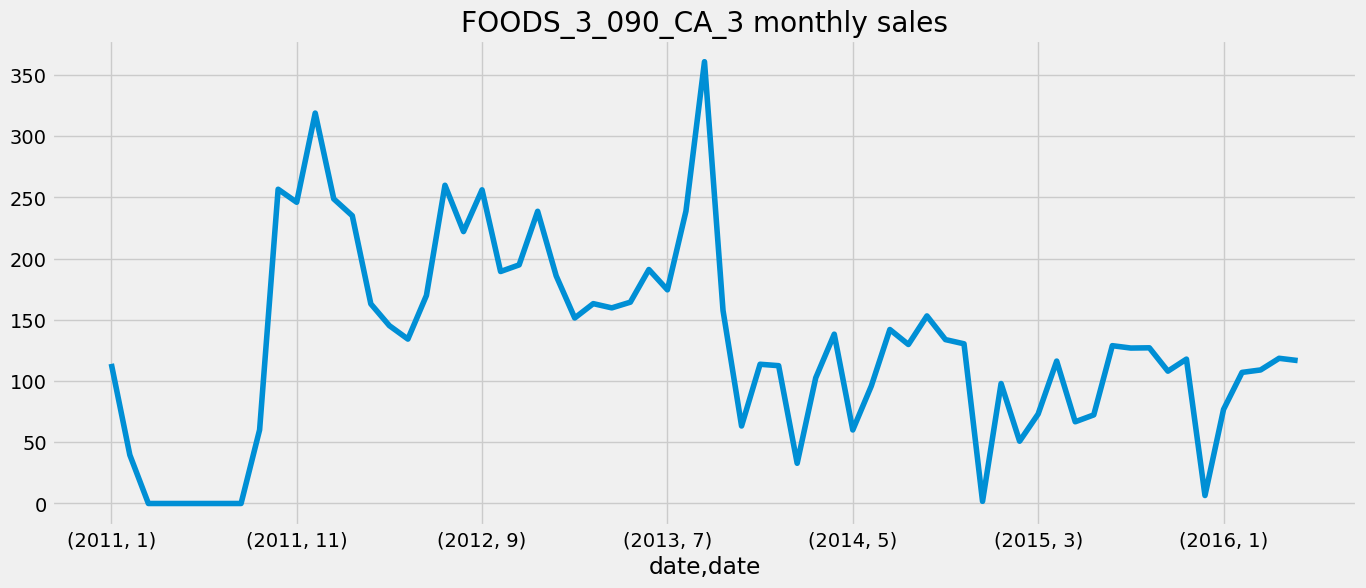

In [16]:
fig = plt.figure(figsize=(15, 6))
df_product_month_2.plot(kind="line", title="FOODS_3_090_CA_3 monthly sales");

---

### Visualize the sales data by stores

We are provided data for 10 unique stores. What are the total sales per stores?

#### Preparing data

Let us reshape the data into a more convenient form:

In [17]:
d_cols = [col for col in sales.columns if 'd_' in col] 
df2 = sales.set_index('id')[d_cols].T
print(df2.shape)
df2.head()

(1941, 30490)


id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


#### Merge with the calendar data

In [18]:
df2 = df2.merge(cal.set_index('d')['date'],left_index=True,right_index=True,validate='1:1').set_index('date')
print(df2.shape)
df2.head()

(1941, 30490)


,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


#### Check store ids

In [19]:
store_ids = sales.store_id.unique()
store_ids

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

#### Loop over stores and extract their data

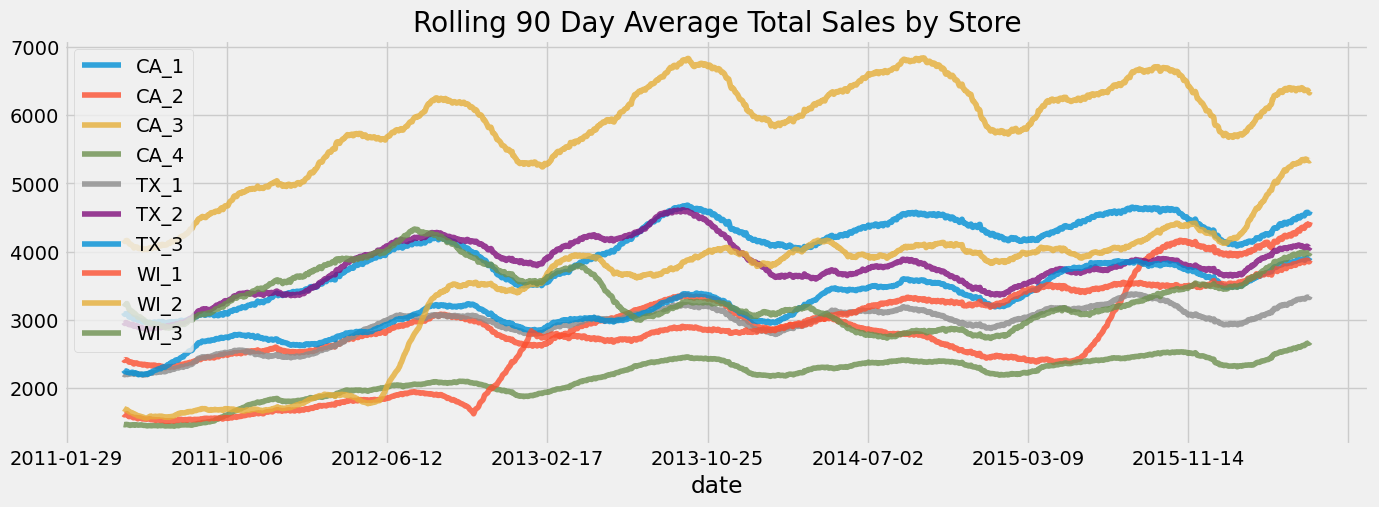

In [20]:
for s in store_ids:
    get_store_cols = [c for c in df2.columns if s in c]
    df2[get_store_cols].sum(axis=1).rolling(90).mean().plot(figsize=(15, 5), alpha=0.8)

plt.title("Rolling 90 Day Average Total Sales by Store")
plt.legend(store_ids)
plt.show()

#### Plot a rolling 7 day total demand by store

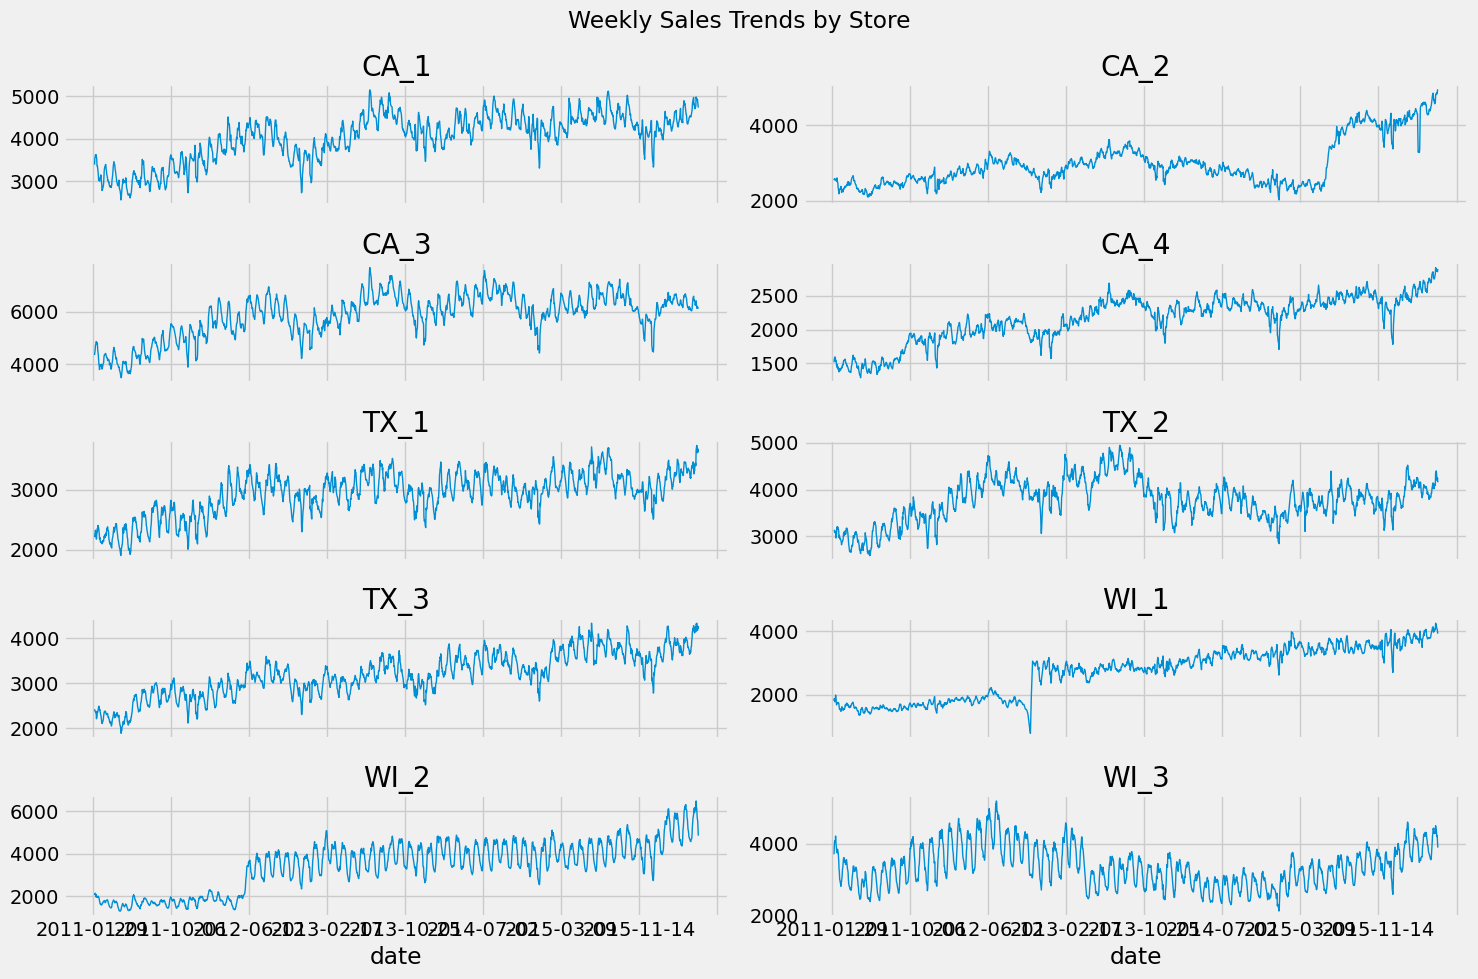

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_ids:
    get_store_cols = [c for c in df2.columns if s in c]
    df2[get_store_cols].sum(axis=1).rolling(7).mean().plot(alpha=1,ax=axes[ax_idx], title=s,lw=1)
    ax_idx += 1

plt.suptitle('Weekly Sales Trends by Store')
plt.tight_layout()
plt.show()

---

<div class="alert-warning">
    We stop here. However, the data exploration could go on. Depending on the task, the descriptive analysis might be more important sometimes.
</div>

---

## <span style="color:steelblue;">  Machine Learning for Time Series Forecasting  </span>

A Machine Learning Pipeline:

- __Data preparation__
- __Feature extraction (sometimes selection):__ what kinds of features to include in our forecast model?
- __Model fitting:__ what kinds of models are suitable for our data?
- __Prediction and Validation:__ How can we train and validate our mode?

### <span style="color:DarkGray;">  Data preparation  </span>

Let us focus only on the stores across the California state.

The goal is predicting item sales at this store for 28-day time periods. 

In [22]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [23]:
sales["state_id"].unique()

array(['CA', 'TX', 'WI'], dtype=object)

In [24]:
sales["store_id"].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

#### Filter California data and melt the dataset

In [25]:
ca_sales = pd.melt(sales.loc[sales["state_id"] == "CA"],
              id_vars = ["id","item_id","dept_id","cat_id","store_id","state_id"],
              value_vars = [col for col in sales.columns if col.startswith("d_")],
              var_name = "d",
              value_name = "sales")
print(ca_sales.shape)
ca_sales.head()

(23672436, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


#### Get date information

In [26]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [27]:
cal["event_name_1"].value_counts()

event_name_1
SuperBowl              6
Pesach End             6
Ramadan starts         6
ValentinesDay          6
NBAFinalsEnd           6
NBAFinalsStart         6
MemorialDay            6
Mother's day           6
Purim End              6
StPatricksDay          6
LentWeek2              6
LentStart              6
PresidentsDay          6
MartinLutherKingDay    5
OrthodoxChristmas      5
EidAlAdha              5
NewYear                5
Chanukah End           5
Christmas              5
Thanksgiving           5
VeteransDay            5
IndependenceDay        5
Halloween              5
ColumbusDay            5
LaborDay               5
Eid al-Fitr            5
Cinco De Mayo          5
OrthodoxEaster         5
Easter                 5
Father's day           4
Name: count, dtype: int64

In [28]:
ca_sales = pd.merge(ca_sales, cal, on='d', how='left')
print(ca_sales.shape)
ca_sales.head(5)

(23672436, 21)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


#### Get price information

In [29]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [30]:
ca_sales = pd.merge(ca_sales, price, on = ["store_id", "item_id", "wm_yr_wk"], how='left')
print(ca_sales.shape)
ca_sales.head(5)

(23672436, 22)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


#### Remove all columns except these:

`id`, `item_id`, `dept_id`, `cat_id`, `store_id`, `date`, `event_name_1`, `sell_price` and `sales`

In [31]:
cols_to_keep = ["id", "item_id", "dept_id", "cat_id", "store_id", "date", "event_name_1", "sell_price","sales"]
ca_sales = ca_sales[cols_to_keep]
ca_sales.head()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0


<div class="alert-danger">
    Note: For the rest of this notebook, we will use the <b>ca_sales</b> DataFrame.
</div>

### <span style="color:DarkGray;">  Feature engineering  </span>

What features do we need <i>to build</i> to improve the forecasts of the retail unit sales?

<div class="alert-success">
Time series data must be re-framed as a supervised learning dataset before we can start using any machine learning algorithms.
</div>

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

__Based on business insights or common sense, we will add additional features, built with existing ones, to help our model to capture all the key factors impacting your customer demand.__

Let us check what are our features sets?

   - Item (product) ids : `id`, `item_id`
   - Store, category and the departement : `store_id`, `cat_id`, `dep_id`
   - Transaction time : `date`
   - Sales price and events : `sell_price`, `event_name_1` 

<div class="alert-info">
    <i>Business insights: What would be the impact of a special event (e.g. -20% reduction) on sales for the second week of the month? </i>
</div>

### Feature set 1 : Lag and rolling mean features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

__lags__ measure the week-on-week or month-on-month (7 days, 28 days) similarities to capture the periodicity of sales due to people shopping at these frequencies.

In [32]:
ca_sales["lag_28"] = ca_sales[["id","sales"]].groupby("id")["sales"].shift(28)

__Rolling means__ measure the average sales of the last __n__ days.

In [33]:
ca_sales["rmean_7"] = ca_sales[["id", "sales"]].groupby("id")["sales"].transform(lambda x : x.rolling(7).mean())

<div class="alert-info">
    <i>Business insights: if the rolling mean of the last 7 days is 40% higher than the average sales of the previous week for sunglasses, that means its a season shift. </i>
</div>

__Rolling means on lag sales__ measure the average sales of a __n__ days windows ending __p__ days ago.

In [34]:
ca_sales["rmean_28_7"] = ca_sales[["id", "lag_28"]].groupby("id")["lag_28"].transform(lambda x : x.rolling(7).mean())

In [80]:
display(ca_sales.head())
display(ca_sales.tail())

NameError: name 'ca_sales' is not defined

__Selling trends__ measure the gap between the daily sales and the average sales.

In [36]:
mean_sales = ca_sales.groupby(['id'])["sales"].transform('mean')

In [37]:
daily_sales = ca_sales.groupby(['id','date'])["sales"].transform('mean')

In [38]:
ca_sales["sell_trend"] = (daily_sales - mean_sales).astype(np.float16)

In [39]:
ca_sales.head()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.326172
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.257568
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.159180
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-1.718750
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.972656


__Rolling max__ looks for the maximum sales in the last __n__ days.

In [40]:
ca_sales["rmax_7"] = ca_sales[["id", "sales"]].groupby("id")["sales"].transform(lambda x: x.rolling(window=7).max()).astype(np.float16)

In [41]:
ca_sales.head()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.326172,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.257568,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.159180,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-1.718750,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.972656,NaN


<div class="alert-info">
    <i>Business insights: sales-related features (mean, maximum, etc.) are critical for sales forecasting. </i>
</div>

__Price delta__ Capture the price evolutions.

<div class="alert-info">
    <i>Business insights: look into this feature might help to consider promotions for slow movers. In order to reduce the inventory and purge slow movers, stores may apply aggressive pricing to boost sales. </i>
</div>

In [42]:
mean_price = ca_sales[["id", "sell_price"]].groupby("id")["sell_price"].transform(lambda x : x.rolling(7).mean())

<div class="alert-success">
    <b>Mean Absolute Deviation (MAD)</b> is a measure of variability that indicates the average distance between observations and their mean. 
</div>

In [43]:
ca_sales["price_mad"] = (ca_sales["sell_price"] - mean_price) / mean_price

In [44]:
ca_sales.head()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7,price_mad
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.326172,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.257568,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.159180,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-1.718750,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.972656,NaN,NaN


In [45]:
ca_sales.tail()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7,price_mad
23672431,FOODS_3_823_CA_4_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_4,2016-05-22,NaN,2.98,0,0.0,1.142857,1.428571,-0.548828,3.0,0.0
23672432,FOODS_3_824_CA_4_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_4,2016-05-22,NaN,2.48,0,1.0,0.857143,0.571429,-0.332764,4.0,0.0
23672433,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,2016-05-22,NaN,3.98,0,0.0,0.857143,1.142857,-0.641113,2.0,0.0
23672434,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,2016-05-22,NaN,1.28,4,4.0,2.000000,3.142857,3.025391,4.0,0.0
23672435,FOODS_3_827_CA_4_evaluation,FOODS_3_827,FOODS_3,FOODS,CA_4,2016-05-22,NaN,1.00,0,8.0,5.142857,3.142857,-0.097351,16.0,0.0


In [46]:
ca_sales.isnull().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
date                   0
event_name_1    21745468
sell_price       5113150
sales                  0
lag_28            341488
rmean_7            73176
rmean_28_7        414664
sell_trend             0
rmax_7             73176
price_mad        5186326
dtype: int64

### Feature set 2 : Datetime based features

Let us use `date` column to create some time-related features.

#### Convert  `date`  column to datetime

In [47]:
ca_sales['date'] = pd.to_datetime(ca_sales['date'])
ca_sales.dtypes

id                      object
item_id                 object
dept_id                 object
cat_id                  object
store_id                object
date            datetime64[ns]
event_name_1            object
sell_price             float64
sales                    int64
lag_28                 float64
rmean_7                float64
rmean_28_7             float64
sell_trend             float16
rmax_7                 float16
price_mad              float64
dtype: object

In [48]:
ca_sales['quarter'] = ca_sales['date'].dt.quarter.astype("int16")
ca_sales['month'] = ca_sales['date'].dt.month.astype("int16")
ca_sales['day'] = ca_sales['date'].dt.day.astype("int16")
ca_sales['weekday'] = ca_sales['date'].dt.weekday.astype("int16")
print("Done")

Done


In [49]:
ca_sales.head()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7,price_mad,quarter,month,day,weekday
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.326172,NaN,NaN,1,1,29,5
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.257568,NaN,NaN,1,1,29,5
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.159180,NaN,NaN,1,1,29,5
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-1.718750,NaN,NaN,1,1,29,5
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,2011-01-29,NaN,NaN,0,NaN,NaN,NaN,-0.972656,NaN,NaN,1,1,29,5


### Encode categorical features

In [50]:
ca_sales.dtypes

id                      object
item_id                 object
dept_id                 object
cat_id                  object
store_id                object
date            datetime64[ns]
event_name_1            object
sell_price             float64
sales                    int64
lag_28                 float64
rmean_7                float64
rmean_28_7             float64
sell_trend             float16
rmax_7                 float16
price_mad              float64
quarter                  int16
month                    int16
day                      int16
weekday                  int16
dtype: object

In [51]:
from sklearn.preprocessing import LabelEncoder
cat_feats = ['item_id', 'dept_id', 'cat_id', 'store_id', 'event_name_1']
for cc in cat_feats:
    le = LabelEncoder()
    ca_sales[cc] = le.fit_transform(ca_sales[cc])

print("Done")

Done


In [52]:
ca_sales.dtypes

id                      object
item_id                  int32
dept_id                  int32
cat_id                   int32
store_id                 int32
date            datetime64[ns]
event_name_1             int32
sell_price             float64
sales                    int64
lag_28                 float64
rmean_7                float64
rmean_28_7             float64
sell_trend             float16
rmax_7                 float16
price_mad              float64
quarter                  int16
month                    int16
day                      int16
weekday                  int16
dtype: object

### Check for null values and drop them

In [53]:
ca_sales.isnull().sum()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
date                  0
event_name_1          0
sell_price      5113150
sales                 0
lag_28           341488
rmean_7           73176
rmean_28_7       414664
sell_trend            0
rmax_7            73176
price_mad       5186326
quarter               0
month                 0
day                   0
weekday               0
dtype: int64

In [54]:
ca_sales.dropna(inplace=True)
print(ca_sales.shape)
ca_sales.head()

(18348483, 19)


,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7,price_mad,quarter,month,day,weekday
414671,HOBBIES_1_008_CA_1_evaluation,1444,3,1,0,2011-03-04,30,0.42,0,6.0,0.000000,5.285714,-7.285156,0.0,0.0,1,3,4,4
414672,HOBBIES_1_009_CA_1_evaluation,1445,3,1,0,2011-03-04,30,1.56,2,3.0,1.428571,2.428571,0.821777,8.0,0.0,1,3,4,4
414673,HOBBIES_1_010_CA_1_evaluation,1446,3,1,0,2011-03-04,30,3.17,0,0.0,0.000000,0.142857,-0.716797,0.0,0.0,1,3,4,4
414675,HOBBIES_1_012_CA_1_evaluation,1448,3,1,0,2011-03-04,30,5.98,0,0.0,0.142857,0.285714,-0.392090,1.0,0.0,1,3,4,4
414678,HOBBIES_1_015_CA_1_evaluation,1451,3,1,0,2011-03-04,30,0.72,8,0.0,9.428571,1.285714,1.986328,20.0,0.0,1,3,4,4


### Save and load from pickle

In [55]:
import pickle
ca_sales.to_pickle('ca_sales.pkl')

In [56]:
ca_sales = pd.read_pickle('ca_sales.pkl')
ca_sales.head()

,id,item_id,dept_id,cat_id,store_id,date,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7,price_mad,quarter,month,day,weekday
414671,HOBBIES_1_008_CA_1_evaluation,1444,3,1,0,2011-03-04,30,0.42,0,6.0,0.000000,5.285714,-7.285156,0.0,0.0,1,3,4,4
414672,HOBBIES_1_009_CA_1_evaluation,1445,3,1,0,2011-03-04,30,1.56,2,3.0,1.428571,2.428571,0.821777,8.0,0.0,1,3,4,4
414673,HOBBIES_1_010_CA_1_evaluation,1446,3,1,0,2011-03-04,30,3.17,0,0.0,0.000000,0.142857,-0.716797,0.0,0.0,1,3,4,4
414675,HOBBIES_1_012_CA_1_evaluation,1448,3,1,0,2011-03-04,30,5.98,0,0.0,0.142857,0.285714,-0.392090,1.0,0.0,1,3,4,4
414678,HOBBIES_1_015_CA_1_evaluation,1451,3,1,0,2011-03-04,30,0.72,8,0.0,9.428571,1.285714,1.986328,20.0,0.0,1,3,4,4


### <span style="color:DarkGray;">  Train and test split  </span>

Let us split our data into the __train__ and __test__ datasets. 

Note: We are putting aside the last 28 days of data for the test.

In [57]:
ca_sales["date"].min(), ca_sales["date"].max()

(Timestamp('2011-03-04 00:00:00'), Timestamp('2016-05-22 00:00:00'))

In [58]:
split_date = "2016-04-25"

In [59]:
train = ca_sales.loc[ca_sales.date < split_date].copy()
test = ca_sales.loc[ca_sales.date >= split_date].copy()

del ca_sales

In [60]:
print(train.shape)

(18006995, 19)


In [61]:
print(test.shape)

(341488, 19)


### Drop `id` and `date` columns

In [62]:
train.drop(['id', 'date'], axis = 1, inplace = True)
test.drop(['id', 'date'], axis = 1, inplace = True)

In [63]:
train.head()

,item_id,dept_id,cat_id,store_id,event_name_1,sell_price,sales,lag_28,rmean_7,rmean_28_7,sell_trend,rmax_7,price_mad,quarter,month,day,weekday
414671,1444,3,1,0,30,0.42,0,6.0,0.000000,5.285714,-7.285156,0.0,0.0,1,3,4,4
414672,1445,3,1,0,30,1.56,2,3.0,1.428571,2.428571,0.821777,8.0,0.0,1,3,4,4
414673,1446,3,1,0,30,3.17,0,0.0,0.000000,0.142857,-0.716797,0.0,0.0,1,3,4,4
414675,1448,3,1,0,30,5.98,0,0.0,0.142857,0.285714,-0.392090,1.0,0.0,1,3,4,4
414678,1451,3,1,0,30,0.72,8,0.0,9.428571,1.285714,1.986328,20.0,0.0,1,3,4,4


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18006995 entries, 414671 to 23330947
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       int32  
 1   dept_id       int32  
 2   cat_id        int32  
 3   store_id      int32  
 4   event_name_1  int32  
 5   sell_price    float64
 6   sales         int64  
 7   lag_28        float64
 8   rmean_7       float64
 9   rmean_28_7    float64
 10  sell_trend    float16
 11  rmax_7        float16
 12  price_mad     float64
 13  quarter       int16  
 14  month         int16  
 15  day           int16  
 16  weekday       int16  
dtypes: float16(2), float64(5), int16(4), int32(5), int64(1)
memory usage: 1.5 GB


### Create input (`x`) and output (`y`) variables 

In [65]:
x_train = train.drop(['sales'], axis = 1)
y_train = train["sales"].copy()

x_test = test.drop(['sales'], axis = 1)
y_test = test["sales"].copy()

In [66]:
print(x_train.shape, y_train.shape)

(18006995, 16) (18006995,)


In [67]:
print(x_test.shape, y_test.shape)

(341488, 16) (341488,)


### Normalizations

In [68]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#### Standardization

In [69]:
scaler_std = StandardScaler() 
scaler_std.fit(x_train)

x_train_n = scaler_std.transform(x_train)
x_train_n = pd.DataFrame(x_train_n,columns=x_train.columns)

x_test_n = scaler_std.transform(x_test)
x_test_n = pd.DataFrame(x_test_n,columns=x_test.columns)

#### MinMax Scaling

In [70]:
scaler_mm = MinMaxScaler() 
scaler_mm.fit(x_train)

x_train_n = scaler_mm.transform(x_train)
x_train_n = pd.DataFrame(x_train_n,columns=x_train.columns)

x_test_n = scaler_mm.transform(x_test)
x_test_n = pd.DataFrame(x_test_n,columns=x_test.columns)

#### No Normalization

In [71]:
x_train_n = x_train.copy()
x_test_n = x_test.copy()

---

### Setup evaluation report

In [72]:
from sklearn.metrics import mean_squared_error
results = pd.DataFrame(columns=["MSE"])

---

### <span style="color:DarkGray;"> Model training and validation </span>


### Linear Regression

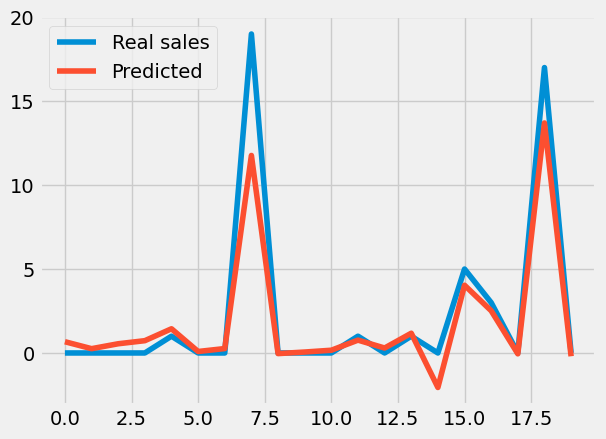

CPU times: total: 29.9 s
Wall time: 11.9 s


,MSE
Linear Regression,1.42569


In [73]:
%%time
from sklearn.linear_model import LinearRegression

# Fitting the model on train
model = LinearRegression()
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Some visuals
plt.plot(y_test.values[0:20], label = "Real sales");
plt.plot(y_pred[0:20], label = "Predicted");
plt.legend(); plt.show();

# Evaluating with MSE
results.loc['Linear Regression'] = mean_squared_error(y_test, y_pred)
results.head()

### Random Forest <span style="color:red; font-style:italic; font-size:10pt; font-weight:300"> Alert!: time-consuming  </span>

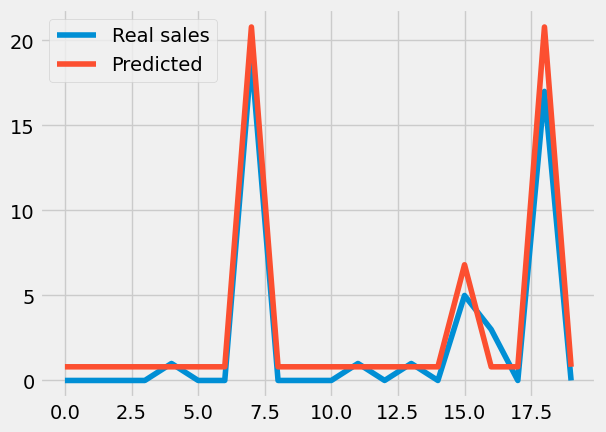

CPU times: total: 28min 56s
Wall time: 28min 57s


,MSE
Linear Regression,1.425690
Random Forest,5.765122


In [74]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Fitting the model on train
model = RandomForestRegressor(max_depth=2, random_state=0)
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Some visuals
plt.plot(y_test.values[0:20], label = "Real sales");
plt.plot(y_pred[0:20], label = "Predicted");
plt.legend(); plt.show();

# Evaluating with MSE
results.loc['Random Forest'] = mean_squared_error(y_test, y_pred)
results.head()

### XGBoost  <span style="color:red; font-style:italic; font-size:10pt; font-weight:300"> Alert!: time-consuming  </span>

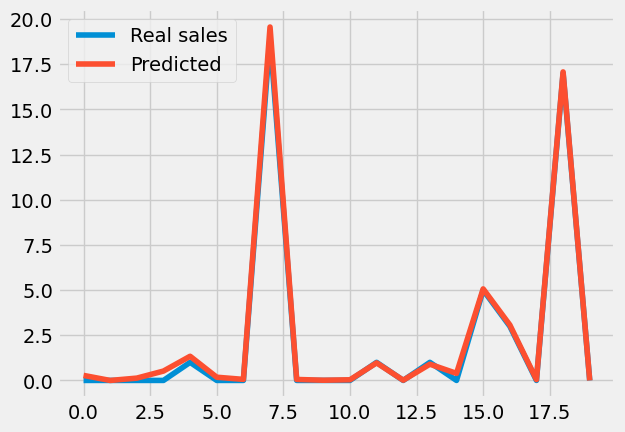

CPU times: total: 30min 54s
Wall time: 3min 53s


,MSE
Linear Regression,1.425690
Random Forest,5.765122
XGBoost,0.523294


In [75]:
%%time
import xgboost as xgb

# Fitting the model on train
model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=300)
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Some visuals
plt.plot(y_test.values[0:20], label = "Real sales");
plt.plot(y_pred[0:20], label = "Predicted");
plt.legend(); plt.show();

# Evaluating with MSE
results.loc['XGBoost'] = mean_squared_error(y_test, y_pred)
results.head()

### Light GBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 18006995, number of used features: 16
[LightGBM] [Info] Start training from score 1.569423


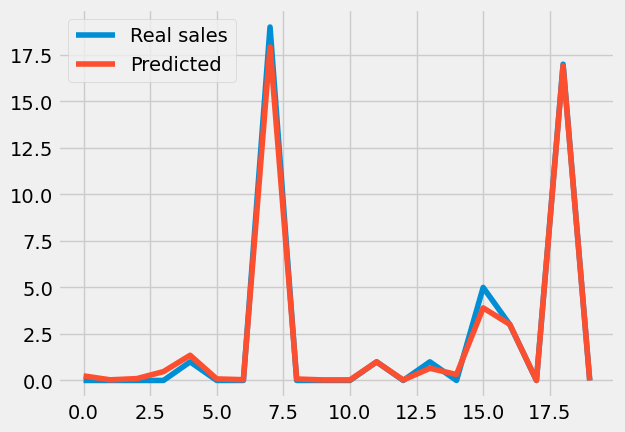

CPU times: total: 3min 38s
Wall time: 38.8 s


,MSE
Linear Regression,1.425690
Random Forest,5.765122
XGBoost,0.523294
LGBM,0.654237


In [76]:
%%time
import lightgbm as lgb

# Fitting the model on train
model = lgb.LGBMRegressor()
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Some visuals
plt.plot(y_test.values[0:20], label = "Real sales");
plt.plot(y_pred[0:20], label = "Predicted");
plt.legend(); plt.show();

# Evaluating with MSE
results.loc['LGBM'] = mean_squared_error(y_test, y_pred)
results.head()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

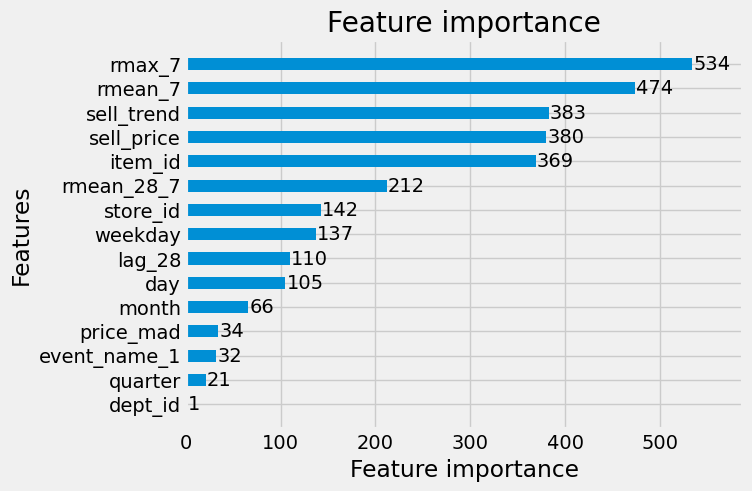

In [77]:
lgb.plot_importance(model,height = 0.5)

### Light GBM (Advanced)  <span style="color:red; font-style:italic; font-size:10pt; font-weight:300"> Alert!: time-consuming  </span>

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.310406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 18006995, number of used features: 16
[LightGBM] [Info] Start training from score 1.569423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

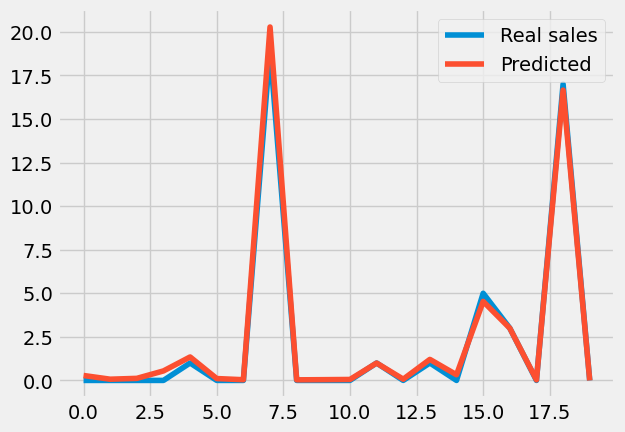

CPU times: total: 33min 29s
Wall time: 5min 36s


,MSE
Linear Regression,1.425690
Random Forest,5.765122
XGBoost,0.523294
LGBM,0.654237
LGBM Advanced,0.427129


In [78]:
%%time
import lightgbm as lgb

# Fitting the model on train
model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300)
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Some visuals
plt.plot(y_test.values[0:20], label = "Real sales");
plt.plot(y_pred[0:20], label = "Predicted");
plt.legend(); plt.show();

# Evaluating with MSE
results.loc['LGBM Advanced'] = mean_squared_error(y_test, y_pred)
results.head()

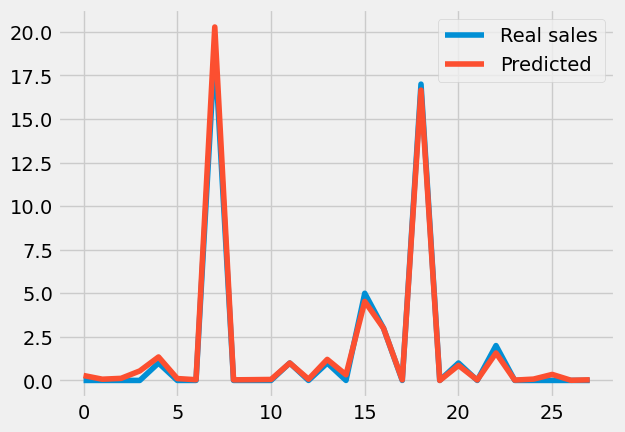

In [81]:
# Some visuals
plt.plot(y_test.values[0:28], label = "Real sales");
plt.plot(y_pred[0:28], label = "Predicted");
plt.legend(); plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

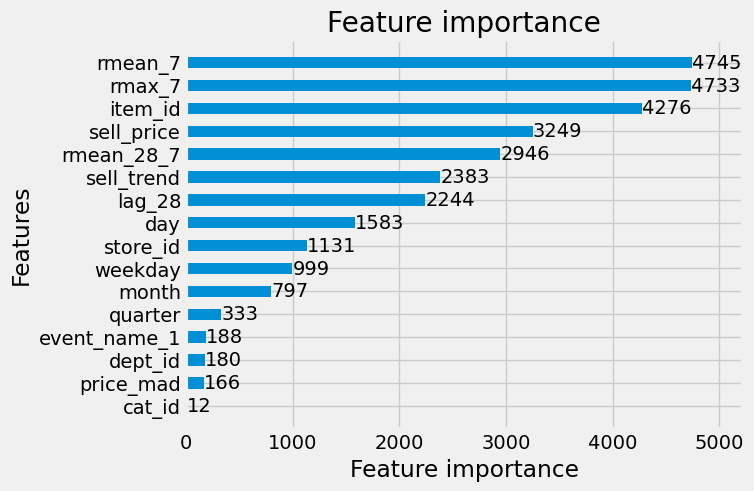

In [79]:
lgb.plot_importance(model,height = 0.5)

---

<div class="alert-info" style="background-color:#ece4f5;">
    <span style="font-weight:bold; color:#8966b0;">
        <h4 style="padding-top:4px; padding-bottom:4px"> EXERCISES 02 - TRY IT YOURSELF </h4>
    </span>
</div>

---